# Chapter 4 - Training Models

This notebook contains the code for chapter 4

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Linear regression

Two different ways of training: 

* Direct closed-form application: directly computes the model parameters that best fit the model to the training set
* Iterative approach (Gradient Descent - GD): gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method
    * Batch GD
    * Mini-batch GD
    * Stochastic GD 
    
A linear model makes a **prediciton** by computing a weighted sum of the input features, plus a constant called *bias term* or *intercept*

$\hat{y} = {\theta}_{0} + {\theta}_{1}{x}_{1} + {\theta}_{2}{x}_{2} + ... + {\theta}_{n}{x}_{n}$ 


Where: 
* $\hat{y}$ = predicted value
* $n$ = number of features
* ${x}_{i}$ = ${i}^{th}$ feature 
* ${\theta}_{j}$ = ${j}^{th}$ model parameter (including the bias term ${\theta}_{0}$ and feature weights ${\theta}_{1}$, ${\theta}_{2}$, ..., ${\theta}_{n}$)

**Vectorised** form: 

$\hat{y} = {h}_{\boldsymbol{\theta}}(x) = \boldsymbol{\theta} \cdot \boldsymbol{x}$ 

Where: 
* ${\theta}$ = model’s *parameter vector*, containing the bias term ${\theta}_{0}$ and the feature
weights ${\theta}_{1}$ to ${\theta}_{n}$
* $x$ = instance’s *feature vector*, containing ${x}_{0}$ to ${x}_{n}$, with ${x}_{0}$ always equal to 1
* $\boldsymbol{\theta} \cdot \boldsymbol{x}$ = is the dot product of the vectors $\boldsymbol{\theta}$ and $x$, which is of course equal to ${\theta}_{0}{x}_{0} + {\theta}_{1}{x}_{1} + {\theta}_{2}{x}_{2} + ... + {\theta}_{n}{x}_{n}$ 
* $h{\theta}$ = hypothesis function, using the model parameters $\boldsymbol{\theta}$

Vectors are represented as *column vectors*: 2D array with single column, then the matrix multiplication can be seen as:  

$\hat{y} = \boldsymbol{\theta}^{T}\boldsymbol{x}$ 


*Process*
* **Training**: setting model's parameters so that it bests fit the training set
* **Performance evaluation**: Root Mean Squared Error (RMSE)
* For Linear regression model: find the value of $\boldsymbol{theta}$ that minimises RMSE
* Easier to minimise MSE (as results the same)

$MSE(\boldsymbol{X}, {h}_{\boldsymbol{\theta}}) = \frac{1}{m} \sum_{i=1}^m(\boldsymbol{\theta}^{T}\boldsymbol{x}^{(i)} - y^{(i)})^2$

### Normal equation

Closed-form method: mathematical equation that finds the value of $\boldsymbol{\theta}$ that minimises the cost funcion MSE

**Normal equation**

$\hat{\boldsymbol\theta} = (\boldsymbol{X}^{T}\boldsymbol{X})^{-1} \boldsymbol{X}^{T} \boldsymbol{y}$ 

Where: 
* $\hat{\boldsymbol\theta}$ = value of ${\boldsymbol\theta}$ that minimises the cost function
* $\boldsymbol{y}$ = vector of target values containing ${y}^{(1)}$ to ${y}^{(m)}$

{}

In [31]:
# Generate linear looking data to test the equation using y = 4 + 3x

import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


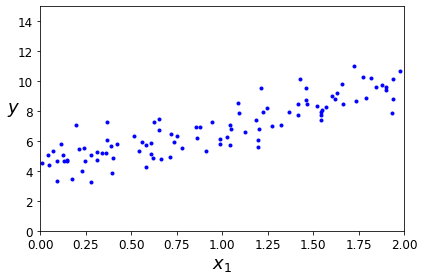

In [4]:
# Plot the data
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

Compute $\hat{\boldsymbol{\theta}}$ using: 
* `inv()` to calculate the inverse of a matrix
* `dot()` for matrix multiplication

In [8]:
# Add X0=1 for all instances
X_b = np.c_[np.ones((100, 1)), X] 

# Calculate theta
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

The expected values are ${\theta}_{0}$ = 4 and ${\theta}_{1}$ = 3

Use $\hat{\boldsymbol{\theta}}$ to make predictions.

In [9]:
# Create new array 
X_new = np.array([[0], [2]])
# Add x0 = 1 to each instance
X_new_b = np.c_[np.ones((2, 1)), X_new] 

# Predict
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

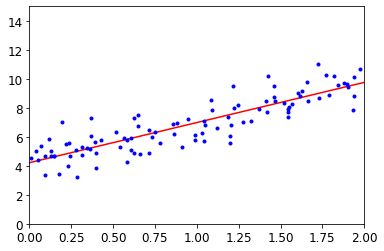

In [10]:
# Plot predictions 

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

**Scikit Learn** can be used to perform Linear Regression

In [11]:
# Import and instantiate model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

# Fit
lin_reg.fit(X, y)

# Print bias term and features weights 
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

The function is based on `scipy.linalg.lstsq()` which computes the *pseudoinverse* of $\boldsymbol{X}$ based on *Singular Value Decomposition (SVD)*

## Gradient Descent

Tweak parameters iteratively in order to minimise the cost function: 

* Assign a random value to $\boldsymbol{\theta}$
* Measure the local gradient of the error function
* At each step, go in the direction of the descending gradient
* The size of the steps is determined by the *learning rate*. 
* Finally converge to a minimum 

Ensure that all features have a similar scale (e.g., using Scikit-Learn’s `StandardScaler` class), or else it will take much longer to converge. 

### Batch Gradient Descent

Uses the whole batch of training data at every step. 

* Find a good **learning rate**: use grid search, but limit the number of iterations to eliminate models that don't converge
* Set the **number of iterations**: set a very large number of iterations and interrupt the algorithm when the gradient vector becomes smaller than the *tolerance* $\epsilon$


### Stochastic Gradient Descent

Picks a *random* instance in the training set at every step and computes the gradients based only on that single instance: 
* Good to escape from the local optima
* Never settle to the minimum

Gradually **reduce the learning rate** using the *learning schedule* function to determine the learning rate at each step. 

Perform using the `SGDRegressor` class. 



In [13]:
# Import and instantiate
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)

# Fit (ravel to flatten the array)
sgd_reg.fit(X, y.ravel())

# Check parameters
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

### Mini-batch Gradient Descent

Computes the gradients on small random sets of instances called mini-batches

**Comparison of algorithms for linear regression**

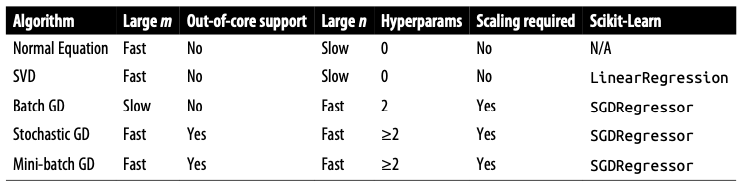

## Polynomial regression

Use linear regression to fit non linear data: add powers of each feature as new features, then train a linear model on this extended set of features. 

In [14]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [15]:
# Generate non linear data
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Saving figure quadratic_data_plot


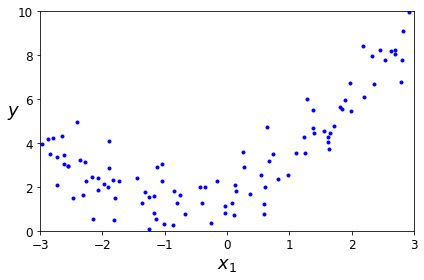

In [16]:
# Plot the data
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [17]:
# Import and instantiate class
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# Transform data
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

In [19]:
# Fit linear regression and get parameters
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

When there are multiple features, Polynomial Regression is capable of finding relationships between features: adds all combinations of features up to the given degree. For example, if there were two features a and b, PolynomialFeatures with degree=3 would not only add the features a2, a3, b2, and b3, but also the combinations ab, a2b, and ab2.

PolynomialFeatures(degree=d) transforms an array containing n features into an array containing $(n + d)! / d!n!$ features, where $n!$ is the factorial of $n$, equal to $1 × 2 × 3 × ⋯ × n$. 

## Learning Curves

How to detect **underfitting** or **overfitting**: 
* Cross validation: estimate the model generalisation performance
* Learning curves: plot the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration)

In [28]:
# Define function to plot curves

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

Saving figure underfitting_learning_curves_plot


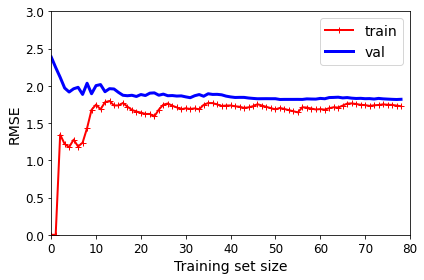

In [29]:
# Plot curves from linear model
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3]) 
save_fig("underfitting_learning_curves_plot")
plt.show()

*Underfitting model*

Both curves reaches a plateau and they are very close to each other. 

On TRAIN data 
* Fit well on a few data (close to zero)
* Increases with the addition of new data
* Reaches plateau: adding more data doesn't improve the performance

On VALIDATION data: 
* Big error on few data, because it cannot generalise
* Adding data it learns, so the error goes down
* Plateau, close to the other curve

To improve: increase model complexity

Saving figure learning_curves_plot


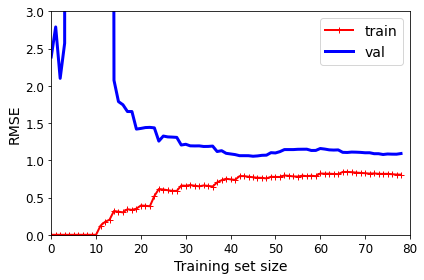

In [30]:
# Plot curves form polynomial model

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
save_fig("learning_curves_plot")  
plt.show()      

*Overfitting model*

* Error on training data is lower than the one with Linear regression
* Gap between the curves: performs better on the train data compared to the validation data. On a larger train set they will get close

To improve: feed more training data till the validation error reaches the training error


#### The bias/variance trade-off

A model’s generalization error can be expressed as the sum of three errors
* Bias: wrong assumption
    * i.e. assumption of linearity instead of quadratic
    * Underfit training data
* Variance: excessive sensibility to variations in training data
    * i.e. too many degrees of freedom (high polynomial)
    * Overfit
* Irreducible error: noisiness of the data 
    * Clean up the data to remove
    
Increasing a model’s complexity will typically increase its variance and reduce its bias. 
Reducing a model’s complexity increases its bias and reduces its variance.


## Regularised linear models

To reduce overfitting: regularize the linear model (constrain): with few degrees of freedom it's hard to overfit the data. 

* Polynomial model: reduce the number of polynomial degrees
* Linear model: constrain the weights of the model 

### Ridge Regression

*Ridge regression* (or *Tikhonov regularisation*): regularised form of Linear Regression

Add *regularisation term* to cost function: 

${\alpha}\sum_{i=1}^n{\theta}_{i} ^2$

Force learning algorithm
* Fit the data
* Keep the model's weights as small as possible 

Used only during **training**. Once the model is trained, use the unregularised performance measure to evaluate the model performance. It is common for the cost function used during training to be different from the performance measure used for testing. 

**Ridge regression cost function**

$ J(\boldsymbol{\theta}) =  MSE(\boldsymbol{\theta}) + {\alpha}\frac{1}{2}\sum_{i=1}^n{\theta}_{i} ^2$

The bias term ${\theta}_0$ is not regularised. 

**Vector form**

Define $\boldsymbol{w}$ as the vector of feature weights ${\theta}_1$ to ${\theta}_n$, then the regularisation term is equal to: 

$\frac{1}{2}(||\boldsymbol{w}||_2)^2$

Where $||\boldsymbol{w}||_2$ represents the ${l}_2$ norm of the weight vector.

i.e. for Gradient Descent: add ${\alpha}\boldsymbol{w}$ to MSE gradient vector

**Data scaling**

Important to scale the data (`StandardScaler`) as sensitive of the scale of the input features, as most of the regularised models. 

**Hyperparameter ${\alpha}$**

Controls how much you want to regularise of the model. 

${\alpha} = 0$

Same as linear regression 

${\alpha}$ very large

* Weights very close to zero
* Result is flat line going through the mean

In [34]:
# Get data
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

Saving figure ridge_regression_plot


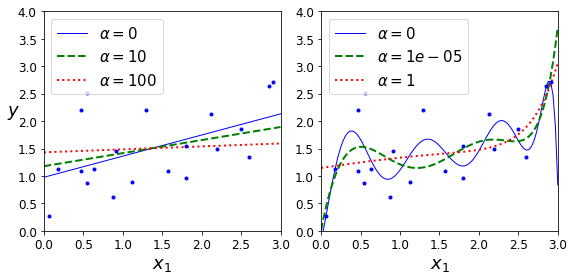

In [35]:
# Plot linear and polynomial with different values of alpha
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
# Linear predictions
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
# Polynomial predictions
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

Increasing ${\alpha}$ leads to flatter (i.e., less extreme, more reasonable) predictions, thus reducing the model’s variance but increasing its bias. 

Ridge Regression computation
* Closed form
* Gradient descent

**Closed form**

$\hat{\boldsymbol\theta} = (\boldsymbol{X}^{T}\boldsymbol{X}+{\alpha}\boldsymbol{A})^{-1} \boldsymbol{X}^{T} \boldsymbol{y}$ 

Where:

$\boldsymbol{A}$: $(n+1)\times(n-1)$ identity matrix except with a 0 in the top left cell (bias term)

Scikit Learn can be used to compute the closed form, using `Cholesky` matrix factorisation technique.

`Solver` to use in the computational routines:
* `cholesky` uses the standard `scipy.linalg.solve` function to obtain a closed-form solution


In [36]:
# Instantiate, fit and predict
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

**Stochastic Gradient Descent**

- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses
      its improved, unbiased version named SAGA. Both methods also use an
      iterative procedure, and are often faster than other solvers when
      both n_samples and n_features are large. Note that 'sag' and
      'saga' fast convergence is only guaranteed on features with
      approximately the same scale. You can preprocess the data with a
      scaler from sklearn.preprocessing.